In [71]:
from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.preprocessing import LabelBinarizer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import custom_funcs as cf

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, I will write the code that is necessary for training on the training set, and testing on the test set.

In [9]:
# Read in the protease inhibitor data
data = pd.read_csv('drug_data/hiv-protease-data.csv', index_col='SeqID')
drug_cols = data.columns[0:8]
feat_cols = data.columns[8:]

# Read in the consensus data
consensus = SeqIO.read('hiv-protease-consensus.fasta', 'fasta')

consensus_map = {i:letter for i, letter in enumerate(str(consensus.seq))}

# Because there are '-' characters in the dataset, representing consensus sequence at each of the positions, 
# they need to be replaced with the actual consensus letter.

for i, col in enumerate(feat_cols):
    # Replace '-' with the consensus letter.
    data[col] = data[col].replace({'-':consensus_map[i]})
    
    # Replace '.' with np.nan
    data[col] = data[col].replace({'.':np.nan})
    
    # Replace 'X' with np.nan
    data[col] = data[col].replace({'X':np.nan})
    
# Drop any feat_cols that have np.nan inside them. We don't want low quality sequences.
data.dropna(inplace=True, subset=feat_cols)
data

,FPV,ATV,IDV,LPV,NFV,SQV,TPV,DRV,P1,P2,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
SeqID,,,,,,,,,,,,,,,,,,,,,
2996,2.5,NaN,16.3,NaN,38.6,16.1,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
4387,0.7,NaN,0.8,NaN,0.8,1.1,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4432,1.5,NaN,1.0,NaN,2.2,1.1,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4482,3.9,NaN,20.2,NaN,21.6,9.2,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
4486,9.5,20.0,8.2,11.0,72.0,46.0,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4538,NaN,NaN,21.0,7.5,55.0,85.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
4664,3.1,NaN,8.7,NaN,32.0,16.9,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
4690,4.9,15.0,18.0,5.9,24.0,73.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
4698,1.2,NaN,0.7,NaN,3.6,1.3,NaN,NaN,P,Q,...,L,T,Q,L,G,C,T,L,N,F


In [12]:
# Grab out the drug name to be tested.
DRUG = drug_cols[0]

# I have written a custom function that takes in the data, and reduces it such that we only consider one drug column
# value, and the corresponding amino acid sequences. The NaN values are also dropped, as most machine learning
# algorithms in scikit-learn cannot deal with NaN values. Finally, the data are log10 transformed.
X, Y = cf.split_data_xy(data, feat_cols, DRUG)

# Binarize the sequence features such that there are 99 x 20 columns in total.
# The purpose of binarizing is to turn the string labels into numeric labels. The most naive way to do this is to 
# take every amino acid position in the sequence alignment, and turn it into 20 columns of 1s and 0s corresponding 
# to whether a particular amino acid is present or not.

lb = LabelBinarizer()
lb.fit(list('CHIMSVAGLPTRFYWDNEQK'))

X_binarized = pd.DataFrame()

for col in X.columns:
    binarized_cols = lb.transform(X[col])
    
    for i, c in enumerate(lb.classes_):
        X_binarized[col + '_' + c] = binarized_cols[:,i]
X_binarized

,P1_A,P1_C,P1_D,P1_E,P1_F,P1_G,P1_H,P1_I,P1_K,P1_L,...,P99_M,P99_N,P99_P,P99_Q,P99_R,P99_S,P99_T,P99_V,P99_W,P99_Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Next step is to split the data into a training set and a test set. 
# We use the train_test_split function provided by the scikit-learn package to do this.
tts_data = X_train, X_test, Y_train, Y_test = train_test_split(X_binarized, Y, test_size=0.33)

We will skip past a discussion of other regresison models, and instead focus here on the use of ensemble regressors.

I would encourage you to take a look at the documentation for each of the following regressors:

- Random Forest
- Gradient Boosting
- AdaBoost
- ExtraTrees
- Bagging

The purpose is to look for parameters that you can tweak to make the model better.

I have written a custom function called `train_model` that takes in

- the train/test splitted data, 
- a model, and 
- model arguments, 

and returns (in order):

- the trained model, 
- the model predictions, 
- the mean-squared error of the predictions, 
- and the correlation score (r-squared).

In [34]:
# Train a bunch of ensemble regressors:

## Random Forest
kwargs = {'n_jobs':-1, 'n_estimators':1000}
rfr, rfr_preds, rfr_mse, rfr_r2 = cf.train_model(*tts_data, model=RandomForestRegressor, modelargs=kwargs)

## Gradient Boosting
kwargs = {'n_estimators':1000}
gbr, gbr_preds, gbr_mse, gbr_r2 = cf.train_model(*tts_data, model=GradientBoostingRegressor, modelargs=kwargs)

## AdaBoost
kwargs = {'n_estimators':1000}
abr, abr_preds, abr_mse, abr_r2 = cf.train_model(*tts_data, model=AdaBoostRegressor, modelargs=kwargs)

## ExtraTrees
kwargs = {'n_estimators':1000, 'n_jobs':-1}
etr, etr_preds, etr_mse, etr_r2 = cf.train_model(*tts_data, model=ExtraTreesRegressor, modelargs=kwargs)

## Bagging
bgr, bgr_preds, bgr_mse, bgr_r2 = cf.train_model(*tts_data, model=BaggingRegressor)

In [35]:
# Compare the trained models. Which one minimizes the mean squared error the most?

rfr_mse, gbr_mse, abr_mse, etr_mse, bgr_mse

(0.51098546097077824,
 0.39687267443239377,
 0.63447066949977826,
 0.95189480815672478,
 0.56501439438813472)

In [39]:
# Qualitatively, what is the math behind the MSE score? Are you looking to minimize or maximize it?

In [77]:
models = dict()
models['rfr'] = RandomForestRegressor(n_estimators=100, n_jobs=-1)
models['gbr'] = GradientBoostingRegressor(n_estimators=100)
models['abr'] = AdaBoostRegressor(n_estimators=100)
models['etr'] = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
models['bgr'] = BaggingRegressor()

model_stats = dict()
model_stats['std'] = dict()
model_stats['mean'] = dict()

scores = cross_val_score(models['etr'], X_binarized, Y, cv=ShuffleSplit(n=len(Y)))
scores

array([ 0.7190695 ,  0.77976093,  0.74160985,  0.66737099,  0.76413052,
        0.69721195,  0.79750958,  0.64488772,  0.76316915,  0.7827427 ])

In [37]:
# Using the coding pattern illustrated above, tweak the parameters as documented in the scikit-learn documentation.
# Can you improve the model predictions? 
"""
Basically, the idea is to tweak the parameters.

"""

In [52]:
# Pick the model that gives the best MSE score (minimize MSE score), and use it to make predictions.

# Read in the sequence data for sequences that do not have predictions made.
proteases_alignment = [s for s in SeqIO.parse('HIV1-protease.fasta', 'fasta') if len(s) == len(consensus.seq)]
proteases_alignment = MultipleSeqAlignment(proteases_alignment)
proteases_alignment

<<class 'Bio.Align.MultipleSeqAlignment'> instance (156223 records of length 99, SingleLetterAlphabet()) at 7fcb22f129b0>

In [65]:
# Binarize the mutliple sequence alignment.
proteases_df = pd.DataFrame()

for col in range(proteases_alignment.get_alignment_length()):
    binarized_cols = lb.transform([k for k in proteases_alignment[:,col]])
    
    for i, c in enumerate(lb.classes_):
        proteases_df[str(col) + '_' + c] = binarized_cols[:,i]
        
# Add in the index.
index = []
for s in proteases_alignment:
    index.append(s.id)
    
proteases_df.index = index

In [66]:
proteases_df

,0_A,0_C,0_D,0_E,0_F,0_G,0_H,0_I,0_K,0_L,...,98_M,98_N,98_P,98_Q,98_R,98_S,98_T,98_V,98_W,98_Y
B.FR.1983.IIIB_LAI.A04321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D.CD.1983.ELI_patent.A07108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1DK.CD.1985.MAL_patent.A07116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B.FR.1983.LAI-J19.A07867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D.CD.1983.ELI_patent.A14116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D.CD.1983.NDK_patent.A34828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-.JP.-.R1.AB020911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-.JP.-.R2.AB020912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-.JP.-.R3.AB020913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-.JP.-.R4.AB020914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([  5290.,  36891.,  81608.,  17967.,   6132.,   3612.,   2374.,
          1388.,    581.,    380.]),
 array([-2.30258509, -1.47318013, -0.64377516,  0.1856298 ,  1.01503476,
         1.84443973,  2.67384469,  3.50324966,  4.33265462,  5.16205958,
         5.99146455]),
 <a list of 10 Patch objects>)

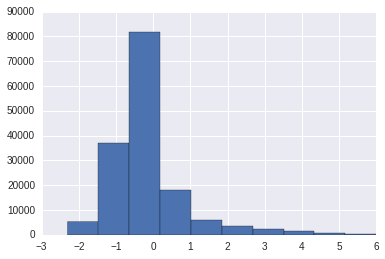

In [70]:
# Make predictions using the best model - ExtraTrees Regressor
etr_preds = etr.predict(proteases_df)
plt.hist(etr_preds)

In [79]:
pd.DataFrame(etr_preds).to_csv('etr_preds.csv')